In [37]:
# Import
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, Ridge,SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [38]:
# Load CSV files (train and test)
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [39]:
df_train = df_train.drop(columns=['id'])
id_test = df_test['id']
df_test= df_test.drop(columns=['id'])

In [9]:
df_train.isnull().sum()/df_train.shape[0]*100

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

In [15]:
#% of null by colums 
df_test.dropna(axis=0,inplace=True)
 #% of null by colums 
df_train.dropna(axis=0,inplace=True)

In [4]:
# Handle missing values in clean_title, fuel_type, and accident
df_train['clean_title'].fillna('Unknown', inplace=True)
df_test['clean_title'].fillna('Unknown', inplace=True)

df_train['fuel_type'] = df_train.groupby(['model', 'model_year'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
df_test['fuel_type'] = df_test.groupby(['model', 'model_year'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

df_train['accident'] = df_train.groupby(['model', 'model_year'])['accident'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
df_test['accident'] = df_test.groupby(['model', 'model_year'])['accident'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

In [40]:
# Add car age and drop model_year
current_year = datetime.now().year
df_train['car_age'] = current_year - df_train['model_year']
df_test['car_age'] = current_year - df_test['model_year']
df_train.drop('model_year', axis=1, inplace=True)
df_test.drop('model_year', axis=1, inplace=True)

In [41]:
# Target encoding for 'model'
mean_price_per_model = df_train.groupby('model')['price'].mean()
df_train['model'] = df_train['model'].map(mean_price_per_model)
df_test['model'] = df_test['model'].map(mean_price_per_model)

# Extract engine power and cylinder
df_train['engine_power'] = df_train['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
df_test['engine_power'] = df_test['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)

df_train['engine_cylinder'] = df_train['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
df_test['engine_cylinder'] = df_test['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)

# Remove the 'engine' column after extraction
df_train.drop('engine', axis=1, inplace=True)
df_test.drop('engine', axis=1, inplace=True)

# Regroup rare colors in 'ext_col' and 'int_col'
color_threshold = 100
ext_color_counts = df_train['ext_col'].value_counts()
rare_ext_colors = ext_color_counts[ext_color_counts < color_threshold].index
df_train['ext_col'] = df_train['ext_col'].replace(rare_ext_colors, 'Other')
df_test['ext_col'] = df_test['ext_col'].replace(rare_ext_colors, 'Other')

int_color_counts = df_train['int_col'].value_counts()
rare_int_colors = int_color_counts[int_color_counts < color_threshold].index
df_train['int_col'] = df_train['int_col'].replace(rare_int_colors, 'Other')
df_test['int_col'] = df_test['int_col'].replace(rare_int_colors, 'Other')

# Remove original columns after processing
df_train.drop(['model', 'ext_col', 'int_col'], axis=1, inplace=True)
df_test.drop(['model', 'ext_col', 'int_col'], axis=1, inplace=True)

# Fill missing engine_power and engine_cylinder with mean values
df_train['engine_power'].fillna(df_train['engine_power'].mean(), inplace=True)
df_test['engine_power'].fillna(df_test['engine_power'].mean(), inplace=True)

df_train['engine_cylinder'].fillna(df_train['engine_cylinder'].mean(), inplace=True)
df_test['engine_cylinder'].fillna(df_test['engine_cylinder'].mean(), inplace=True)

# Créer de nouvelles features basées sur les interactions
df_train['milage_car_age'] = df_train['milage'] * df_train['car_age']
df_train['engine_power_car_age'] = df_train['engine_power'] * df_train['car_age']

df_test['milage_car_age'] = df_test['milage'] * df_test['car_age']
df_test['engine_power_car_age'] = df_test['engine_power'] * df_test['car_age']



In [44]:
# Separate categorical and numerical columns
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.tolist()
# Remove the target from numerical columns
numerical_columns.remove('price')
# Ajouter ces nouvelles colonnes à la liste des colonnes numéri
numerical_columns += ['milage_car_age', 'engine_power_car_age']

In [19]:
# Split features and target
X = df_train.drop(columns=['price']) 
y = df_train['price']

# Apply RobustScaler to numerical columns
scaler = RobustScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X[categorical_columns], prefix=categorical_columns)
X = pd.concat([X[numerical_columns], X_encoded], axis=1)

# Apply same transformations to test set
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns]) 
df_test_encoded = pd.get_dummies(df_test[categorical_columns], prefix=categorical_columns)
df_test = pd.concat([df_test[numerical_columns], df_test_encoded], axis=1)

# Align columns between train and test
X, df_test = X.align(df_test, join='left', axis=1, fill_value=0)

In [20]:
print( f"X train shape afer encoding {X.shape}")
print( f"df_test  shape afer encoding {df_test.shape}")

X train shape afer encoding (162610, 131)
df_test  shape afer encoding (108459, 131)


In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# List of regression models to test
models = [
    
    SGDRegressor(max_iter=1000, tol=1e-3), 
    Lasso(), 
    Ridge(), 
    CatBoostRegressor(silent=True), 
    XGBRegressor(),
    SVR(kernel='linear'),
    LGBMRegressor() 
]

In [30]:
for model in models:
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model.predict(X_test)
    
    # Calculate RMSE on validation set
    rmse = np.sqrt(mean_squared_error(y_test, y_pred) )
    print(f"Model: {model.__class__.__name__}  - RMSE: {rmse}")

Model: SGDRegressor  - RMSE: 78400.5274632798
Model: Lasso  - RMSE: 78151.22764975588
Model: Ridge  - RMSE: 78155.35802850718


CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/features_layout.cpp:120: All feature names should be different, but 'milage_car_age' used more than once.

In [11]:
from sklearn.inspection import PartialDependenceDisplay

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

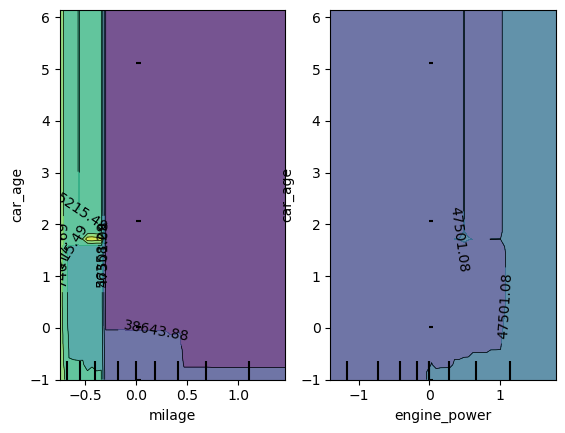

In [15]:
#
from sklearn.inspection import PartialDependenceDisplay


# Vérifier et supprimer les colonnes en double dans X_train et df_test
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

# Modèle LightGBM avec les nouvelles features
model = LGBMRegressor(boosting_type='rf', bagging_freq=1, bagging_fraction=0.8, feature_fraction=0.8, random_state=42)
model.fit(X_train, y_train)

# Visualiser l'interaction entre milage et car_age
features_to_plot = [('milage', 'car_age'), ('engine_power', 'car_age')]
PartialDependenceDisplay.from_estimator(model, X_train, features_to_plot, grid_resolution=50)
plt.show()
